<a href="https://colab.research.google.com/github/Someshwarms/DL-seq-to-seq-encoder-and-decoder-using-LSTM/blob/main/seq_to_seq_encoder_and_decoder_of_spanish_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
num_samples=10000
epochs=100
latent_dim=256
batch_size=64
data_path='/content/drive/MyDrive/spa-txt'

In [4]:
input_texts=[]
target_texts=[]
input_charcters=set()
target_charcters=set()

In [5]:
with open(data_path,'r',encoding="utf-8") as f:
  lines=f.read().split('\n')
  for line in lines[:min(num_samples,len(lines)-1)]:
    input_text,target_text,_=line.split('\t')
    target_text=('\t')+target_text+('\n')
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
      if char not in input_charcters:
        input_charcters.add(char)
    for char in target_text:
      if char not in target_charcters:
        target_charcters.add(char)

input_charcters=sorted(list(input_charcters))
target_charcters=sorted(list(target_charcters))
num_encoder_len=len(input_charcters)
num_decoder_len=len(target_charcters)
max_encoder_seq_len=max([len(txt) for txt in input_texts])
max_decoder_seq_len=max([len(txt) for txt in target_texts])

print("Number of Samples:",num_samples)
print("Length of Input chracter:",num_encoder_len)
print("Length of Target chracter",num_decoder_len)
print("Text length of Encoder:",max_encoder_seq_len)
print("Text length of Decoder:",max_decoder_seq_len)

Number of Samples: 10000
Length of Input chracter: 70
Length of Target chracter 86
Text length of Encoder: 16
Text length of Decoder: 78


In [6]:
input_token_index=dict([(char,i) for i,char in enumerate(input_charcters)])
target_token_index=dict([(char,i) for i,char in enumerate(target_charcters)])

In [7]:
input_token_index

{' ': 0,
 '!': 1,
 '$': 2,
 "'": 3,
 ',': 4,
 '-': 5,
 '.': 6,
 '0': 7,
 '1': 8,
 '2': 9,
 '3': 10,
 '4': 11,
 '5': 12,
 '6': 13,
 '7': 14,
 '8': 15,
 '9': 16,
 ':': 17,
 '?': 18,
 'A': 19,
 'B': 20,
 'C': 21,
 'D': 22,
 'E': 23,
 'F': 24,
 'G': 25,
 'H': 26,
 'I': 27,
 'J': 28,
 'K': 29,
 'L': 30,
 'M': 31,
 'N': 32,
 'O': 33,
 'P': 34,
 'Q': 35,
 'R': 36,
 'S': 37,
 'T': 38,
 'U': 39,
 'V': 40,
 'W': 41,
 'Y': 42,
 'Z': 43,
 'a': 44,
 'b': 45,
 'c': 46,
 'd': 47,
 'e': 48,
 'f': 49,
 'g': 50,
 'h': 51,
 'i': 52,
 'j': 53,
 'k': 54,
 'l': 55,
 'm': 56,
 'n': 57,
 'o': 58,
 'p': 59,
 'q': 60,
 'r': 61,
 's': 62,
 't': 63,
 'u': 64,
 'v': 65,
 'w': 66,
 'x': 67,
 'y': 68,
 'z': 69}

In [8]:
target_token_index

{'\t': 0,
 '\n': 1,
 ' ': 2,
 '!': 3,
 '"': 4,
 "'": 5,
 ',': 6,
 '-': 7,
 '.': 8,
 '0': 9,
 '1': 10,
 '2': 11,
 '3': 12,
 '4': 13,
 '5': 14,
 '6': 15,
 '7': 16,
 '8': 17,
 ':': 18,
 '?': 19,
 'A': 20,
 'B': 21,
 'C': 22,
 'D': 23,
 'E': 24,
 'F': 25,
 'G': 26,
 'H': 27,
 'I': 28,
 'J': 29,
 'K': 30,
 'L': 31,
 'M': 32,
 'N': 33,
 'O': 34,
 'P': 35,
 'Q': 36,
 'R': 37,
 'S': 38,
 'T': 39,
 'U': 40,
 'V': 41,
 'W': 42,
 'Y': 43,
 'Z': 44,
 'a': 45,
 'b': 46,
 'c': 47,
 'd': 48,
 'e': 49,
 'f': 50,
 'g': 51,
 'h': 52,
 'i': 53,
 'j': 54,
 'k': 55,
 'l': 56,
 'm': 57,
 'n': 58,
 'o': 59,
 'p': 60,
 'q': 61,
 'r': 62,
 's': 63,
 't': 64,
 'u': 65,
 'v': 66,
 'w': 67,
 'x': 68,
 'y': 69,
 'z': 70,
 '¡': 71,
 '«': 72,
 '»': 73,
 '¿': 74,
 'Á': 75,
 'É': 76,
 'Ó': 77,
 'Ú': 78,
 'á': 79,
 'é': 80,
 'í': 81,
 'ñ': 82,
 'ó': 83,
 'ú': 84,
 'ü': 85}

In [9]:
encoder_input_data=np.zeros((len(input_texts),max_encoder_seq_len,num_encoder_len),dtype="float32")
decoder_input_data=np.zeros((len(input_texts),max_decoder_seq_len,num_decoder_len),dtype="float32")
decoder_target_data=np.zeros((len(input_texts),max_decoder_seq_len,num_decoder_len),dtype="float32")

In [10]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

In [11]:
encoder_inputs=tf.keras.Input(shape=(None,num_encoder_len))
encoder_lstm=tf.keras.layers.LSTM(latent_dim,return_state=True)
encoder_outputs,state_h,state_c=encoder_lstm(encoder_inputs)
encoder_states=[state_h,state_c]
decoder_inputs=tf.keras.Input(shape=(None,num_decoder_len))
decoder_lstm=tf.keras.layers.LSTM(latent_dim,return_sequences=True,return_state=True)
decoder_outputs,_,_=decoder_lstm(decoder_inputs,initial_state=encoder_states)
decoder_dense=tf.keras.layers.Dense(num_decoder_len,activation="softmax")
decoder_outputs=decoder_dense(decoder_outputs)
model=tf.keras.models.Model([encoder_inputs,decoder_inputs],decoder_outputs)
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 70)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 86)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 334848      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  351232      input_2[0][0]                    
                                                                 lstm[0][1]                   

In [13]:
history=model.fit([encoder_input_data,decoder_input_data],decoder_target_data,batch_size=batch_size,epochs=epochs,validation_split=0.2)

Epoch 1/100
125/125 [==============================] - 14s 49ms/step - loss: 0.9761 - accuracy: 0.8097 - val_loss: 0.7507 - val_accuracy: 0.7900
Epoch 2/100
125/125 [==============================] - 5s 39ms/step - loss: 0.6022 - accuracy: 0.8339 - val_loss: 0.6454 - val_accuracy: 0.8195
Epoch 3/100
125/125 [==============================] - 5s 39ms/step - loss: 0.5177 - accuracy: 0.8570 - val_loss: 0.5634 - val_accuracy: 0.8411
Epoch 4/100
125/125 [==============================] - 5s 41ms/step - loss: 0.4612 - accuracy: 0.8673 - val_loss: 0.5142 - val_accuracy: 0.8500
Epoch 5/100
125/125 [==============================] - 5s 39ms/step - loss: 0.4277 - accuracy: 0.8737 - val_loss: 0.4864 - val_accuracy: 0.8556
Epoch 6/100
125/125 [==============================] - 5s 39ms/step - loss: 0.5237 - accuracy: 0.8584 - val_loss: 0.5114 - val_accuracy: 0.8495
Epoch 7/100
125/125 [==============================] - 5s 39ms/step - loss: 0.4298 - accuracy: 0.8722 - val_loss: 0.4875 - val_accuracy

In [14]:
model.save("enc&dec")

INFO:tensorflow:Assets written to: enc&dec/assets


INFO:tensorflow:Assets written to: enc&dec/assets


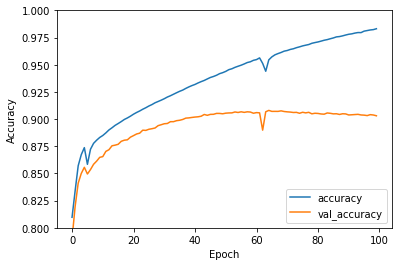

In [15]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')

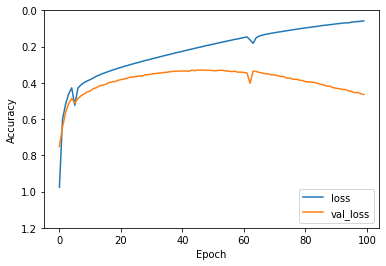

In [16]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([1.2, 0])
plt.legend(loc='lower right')

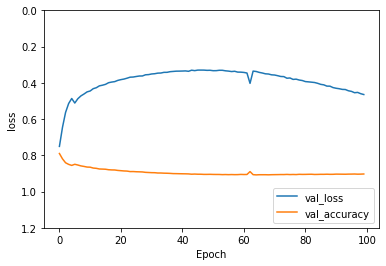

In [17]:
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([1.2,0])
plt.legend(loc='lower right')

In [18]:
X=encoder_input_data,decoder_input_data
y=decoder_target_data
loss,acc=model.evaluate(X,y,verbose=0)
print("Accurcay=",acc*100)
print("Loss=",loss*100)

Accurcay= 96.91807627677917
Loss= 13.373446464538574


In [27]:
model = tf.keras.models.load_model("enc&dec")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = tf.keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = tf.keras.Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = tf.keras.Input(shape=(latent_dim,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = tf.keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_len))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_len:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_len))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [28]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Ve.

-
Input sentence: Go.
Decoded sentence: Ve.

-
Input sentence: Go.
Decoded sentence: Ve.

-
Input sentence: Go.
Decoded sentence: Ve.

-
Input sentence: Hi.
Decoded sentence: Hola.

-
Input sentence: Run!
Decoded sentence: ¡Corred!

-
Input sentence: Run!
Decoded sentence: ¡Corred!

-
Input sentence: Run!
Decoded sentence: ¡Corred!

-
Input sentence: Run!
Decoded sentence: ¡Corred!

-
Input sentence: Run.
Decoded sentence: Corred.

-
Input sentence: Who?
Decoded sentence: ¿Quién?

-
Input sentence: Wow!
Decoded sentence: ¡Órale!

-
Input sentence: Duck!
Decoded sentence: ¡Inclínate!

-
Input sentence: Fire!
Decoded sentence: ¡Fuego!

-
Input sentence: Fire!
Decoded sentence: ¡Fuego!

-
Input sentence: Fire!
Decoded sentence: ¡Fuego!

-
Input sentence: Help!
Decoded sentence: ¡Auxilio!

-
Input sentence: Help!
Decoded sentence: ¡Auxilio!

-
Input sentence: Help!
Decoded sentence: ¡Auxilio!

-
Input sentence: Jump!
Decoded sentence: ¡Salta!

